# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import json
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btcr = requests.get(btc_url)
btc_data = btcr.json()
btc_price = btc_data["data"]["1"]["quotes"]["USD"]["price"]
# Fetch current ETH price
ethr = requests.get(eth_url)
eth_data= ethr.json()
eth_price = eth_data["data"]["1027"]["quotes"]["USD"]["price"]
# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $49201.20
The current value of your 5.3 ETH is $15234.90


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [12]:
# Set current amount of shares data
my_spy = 50
my_agg = 200
df_shares = pd.DataFrame(data = [200,50], columns = ['Units'])

# Set the tickers
tickers = ['AGG','SPY']

# Create the shares DataFrame with `tickers` as index
df_shares.index = tickers

# Display shares data
df_shares

Units
AGG    200
SPY     50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [41]:
# Format current date as ISO format
today = pd.Timestamp("2022-03-09", tz="America/New_York").isoformat()

# Set the tickers
agg = ["AGG"]
spy = ["SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
agg_prices = api.get_bars(agg, tradeapi.TimeFrame.Day, "2022-03-09", "2022-03-09", adjustment='raw').df
spy_prices = api.get_bars(spy, tradeapi.TimeFrame.Day, "2022-03-09", "2022-03-09", adjustment='raw').df

# Preview DataFrame
agg_prices
spy_prices

ticker_prices = pd.concat([agg_prices,spy_prices])
ticker_prices

open     high     low   close     volume  \
timestamp                                                               
2022-03-09 05:00:00+00:00  109.09  109.209  108.93  109.04    9873754   
2022-03-09 05:00:00+00:00  425.16  429.510  422.83  427.41  110780810   

                           trade_count       vwap symbol  
timestamp                                                 
2022-03-09 05:00:00+00:00        29005  109.05872    AGG  
2022-03-09 05:00:00+00:00      1086809  426.13040    SPY

In [42]:
# Pick AGG and SPY close prices
close_prices = ticker_prices.reset_index().set_index('symbol')['close']
share_portfolio = pd.concat([df_shares, close_prices], axis = 'columns')
agg_close_price = share_portfolio.iloc[0]["close"]
spy_close_price = share_portfolio.iloc[1]["close"]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $109.04
Current SPY closing price: $427.41


In [43]:
# Compute the current value of shares
share_portfolio['NPV'] = share_portfolio['Units']*share_portfolio['close']
my_agg_value = share_portfolio.iloc[0]["NPV"]
my_spy_value = share_portfolio.iloc[1]["NPV"]
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21370.50
The current value of your 200 AGG shares is $21808.00


### Savings Health Analysis

In [44]:
# Set monthly household income
monthly_income = 12000


# Consolidate financial assets data
crypto = my_btc_value + my_eth_value
shares = my_agg_value + my_spy_value

assets = ["crypto", "shares"]


# Create savings DataFrame
df_savings = pd.DataFrame(data = [shares, crypto], columns = ["Total"])
df_savings.index = assets

# Display savings DataFrame
df_savings

Total
crypto  43178.500
shares  64436.103

<AxesSubplot:ylabel='Total'>

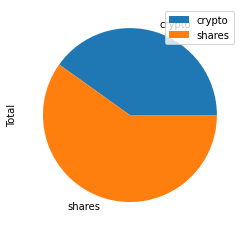

In [45]:
# Plot savings pie chart
df_savings.plot(kind = 'pie', y= 'Total')

In [46]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto + shares

# Validate saving health
if total_savings > emergency_fund:
    print("congratulations, you have enough money in your emergency fund")
elif total_savings == emergency_fund:
    print("congratulations, you've reached your financial goal")
else:
    print(f"{total_savings-emergency_fund} more savings required to reach your financial goal")

congratulations, you have enough money in your emergency fund


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [47]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-03-11', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-03-11', tz='America/New_York').isoformat()

In [55]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
agg_data = api.get_bars(agg, tradeapi.TimeFrame.Day, "2020-03-09", "2022-03-09", adjustment='raw').df
spy_data = api.get_bars(spy, tradeapi.TimeFrame.Day, "2020-03-09", "2022-03-09", adjustment='raw').df
df_stock_data = pd.concat([agg_data,spy_data], keys = ['AGG','SPY'], axis = 1, join = 'inner')

# Display sample data
df_stock_data.head()

AGG                                      \
                             open      high     low   close    volume   
timestamp                                                               
2020-03-09 04:00:00+00:00  119.27  119.2700  117.00  117.71  13667096   
2020-03-10 04:00:00+00:00  117.41  117.6800  116.17  116.38  18701022   
2020-03-11 04:00:00+00:00  116.70  116.7900  114.55  114.72  13342419   
2020-03-12 04:00:00+00:00  113.98  114.7500  109.06  113.05  18687057   
2020-03-13 04:00:00+00:00  111.53  112.4643  110.25  111.86  25174262   

                                                             SPY            \
                          trade_count        vwap symbol    open      high   
timestamp                                                                    
2020-03-09 04:00:00+00:00       48161  118.082037    AGG  275.10  284.1900   
2020-03-10 04:00:00+00:00       46656  116.943340    AGG  284.61  288.5200   
2020-03-11 04:00:00+00:00       43943  115.675755    AGG  280.73  281.9400   
2020-03-12 04:00:00+00:00       61316  111.916937    AGG  256.05  266.6600   
2020-03-13 04:00:00+00:00       72445  111.654115    AGG  263.00  271.4754   

                                                                    \
                                low   close     volume trade_count   
timestamp                                                            
2020-03-09 04:00:00+00:00  273.4500  276.32  309425747     2577867   
2020-03-10 04:00:00+00:00  273.5000  288.41  277866054     2516875   
2020-03-11 04:00:00+00:00  270.8800  274.25  257344789     2152463   
2020-03-12 04:00:00+00:00  247.6800  255.24  394377025     3709931   
2020-03-13 04:00:00+00:00  248.5237  270.20  329754896     2676727   

                                              
                                 vwap symbol  
timestamp                                     
2020-03-09 04:00:00+00:00  280.319722    SPY  
2020-03-10 04:00:00+00:00  281.168620    SPY  
2020-03-11 04:00:00+00:00  277.620270    SPY  
2020-03-12 04:00:00+00:00  255.655013    SPY  
2020-03-13 04:00:00+00:00  258.727547    SPY

In [56]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyears = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [57]:
# Printing the simulation input data
MC_thirtyyears.portfolio_data.head()

AGG                                      \
                             open      high     low   close    volume   
timestamp                                                               
2020-03-09 04:00:00+00:00  119.27  119.2700  117.00  117.71  13667096   
2020-03-10 04:00:00+00:00  117.41  117.6800  116.17  116.38  18701022   
2020-03-11 04:00:00+00:00  116.70  116.7900  114.55  114.72  13342419   
2020-03-12 04:00:00+00:00  113.98  114.7500  109.06  113.05  18687057   
2020-03-13 04:00:00+00:00  111.53  112.4643  110.25  111.86  25174262   

                                                                          SPY  \
                          trade_count        vwap symbol daily_return    open   
timestamp                                                                       
2020-03-09 04:00:00+00:00       48161  118.082037    AGG          NaN  275.10   
2020-03-10 04:00:00+00:00       46656  116.943340    AGG    -0.011299  284.61   
2020-03-11 04:00:00+00:00       43943  115.675755    AGG    -0.014264  280.73   
2020-03-12 04:00:00+00:00       61316  111.916937    AGG    -0.014557  256.05   
2020-03-13 04:00:00+00:00       72445  111.654115    AGG    -0.010526  263.00   

                                                                              \
                               high       low   close     volume trade_count   
timestamp                                                                      
2020-03-09 04:00:00+00:00  284.1900  273.4500  276.32  309425747     2577867   
2020-03-10 04:00:00+00:00  288.5200  273.5000  288.41  277866054     2516875   
2020-03-11 04:00:00+00:00  281.9400  270.8800  274.25  257344789     2152463   
2020-03-12 04:00:00+00:00  266.6600  247.6800  255.24  394377025     3709931   
2020-03-13 04:00:00+00:00  271.4754  248.5237  270.20  329754896     2676727   

                                                           
                                 vwap symbol daily_return  
timestamp                                                  
2020-03-09 04:00:00+00:00  280.319722    SPY          NaN  
2020-03-10 04:00:00+00:00  281.168620    SPY     0.043754  
2020-03-11 04:00:00+00:00  277.620270    SPY    -0.049097  
2020-03-12 04:00:00+00:00  255.655013    SPY    -0.069316  
2020-03-13 04:00:00+00:00  258.727547    SPY     0.058612

In [58]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\dhaam\Documents\Fintech Course\Homework\api_homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

0          1           2          3          4          5    \
0      1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
1      0.987139   0.992529    1.013358   0.997455   0.982145   0.995520   
2      0.999900   1.000048    1.002687   1.004847   0.998567   0.998412   
3      0.994512   0.993777    0.998331   1.004458   0.984709   1.002349   
4      0.995615   0.987961    0.993069   1.008583   0.986863   0.996000   
...         ...        ...         ...        ...        ...        ...   
7556  85.818190  21.494602  208.314440  76.365610  69.164840  17.596354   
7557  85.181498  21.417978  210.044155  76.705176  69.065308  17.751092   
7558  85.064780  21.419001  212.852325  76.868060  69.060769  17.784456   
7559  84.720120  21.173790  215.703215  76.977063  67.965792  17.583932   
7560  85.167676  20.900196  212.403460  76.937077  67.488143  17.517652   

            6          7          8          9    ...        490        491  \
0      1.000000   1.000000   1.000000   1.000000  ...   1.000000   1.000000   
1      0.992171   0.996052   0.992862   0.983081  ...   0.994783   1.008195   
2      1.000412   1.005235   1.006021   0.977351  ...   1.004154   1.008626   
3      1.000649   1.015559   1.005693   0.988624  ...   1.000211   1.001100   
4      1.002141   0.990369   1.005061   0.986578  ...   0.989098   1.017171   
...         ...        ...        ...        ...  ...        ...        ...   
7556  90.044438  41.470779  57.862073  93.417474  ...  44.978389  37.857384   
7557  89.850979  41.577697  57.910050  93.995043  ...  45.175734  37.858256   
7558  88.924522  41.707581  59.268483  94.600310  ...  45.239720  37.819254   
7559  90.053880  41.395701  58.711740  95.036613  ...  45.771755  37.545756   
7560  90.329150  41.221936  59.090663  94.746595  ...  45.862118  37.526579   

             492        493        494        495        496        497  \
0       1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1       1.020853   0.999857   1.000505   1.010734   1.007599   1.024090   
2       1.006405   1.005951   0.984584   1.031022   1.002689   1.011388   
3       0.996577   0.991355   0.990796   1.031432   1.014458   1.016182   
4       0.995932   1.006298   0.978771   1.032781   1.012444   1.027161   
...          ...        ...        ...        ...        ...        ...   
7556  120.599013  92.040821  62.614296  95.418248  55.555336  77.946782   
7557  120.789553  93.866053  62.362742  94.936553  55.765774  78.888816   
7558  120.863450  92.683037  62.412679  95.269027  56.984042  80.974123   
7559  120.522294  92.557245  61.903076  95.226685  56.609308  81.748335   
7560  120.223885  93.091424  62.782782  94.797993  56.120524  81.675560   

            498        499  
0      1.000000   1.000000  
1      0.991226   1.019970  
2      0.978185   1.015677  
3      0.983493   1.019223  
4      0.994617   1.016910  
...         ...        ...  
7556  21.452302  50.239543  
7557  21.544526  50.091084  
7558  21.494065  50.361629  
7559  21.267682  49.942360  
7560  21.390745  49.828484  

[7561 rows x 500 columns]

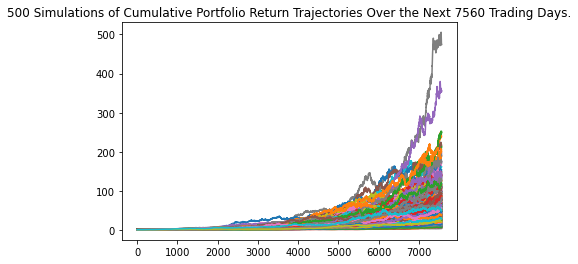

In [59]:
# Plot simulation outcomes
line_plot = MC_thirtyyears.plot_simulation()

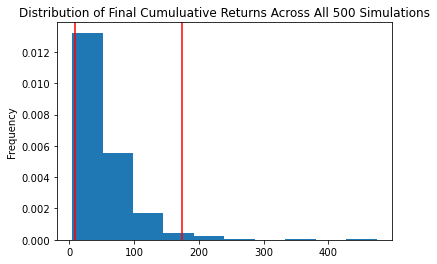

In [60]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyears.plot_distribution()

### Retirement Analysis

In [61]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirtyyears.summarize_cumulative_return()
# Print summary statistics
print(tbl)

count           500.000000
mean             53.081641
std              46.017381
min               4.165789
25%              24.100693
50%              40.575957
75%              66.118138
max             474.342783
95% CI Lower      8.321040
95% CI Upper    173.116771
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [62]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $166420.79 and $3462335.41


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [63]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $249631.19 and $5193503.12


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [64]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyears = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.20,.80],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [198]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\dhaam\Documents\Fintech Course\Homework\api_homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.017071  1.000434  1.007758  0.994908  1.016130  0.997455  1.009021   
2     1.022620  1.004437  1.034539  0.987996  1.007678  1.012981  1.012067   
3     1.015733  0.997197  1.034650  0.984455  1.024054  1.009526  1.011153   
4     1.027328  0.976934  1.026450  0.985617  1.014573  1.023610  1.007667   
...        ...       ...       ...       ...       ...       ...       ...   
1256  2.035990  1.600400  2.453090  1.881466  2.291191  1.207364  2.379558   
1257  2.034930  1.608301  2.453717  1.877839  2.287704  1.210419  2.389338   
1258  2.038759  1.592445  2.445492  1.869271  2.277645  1.218933  2.388616   
1259  2.030937  1.587887  2.427469  1.888815  2.254348  1.220862  2.383204   
1260  2.062655  1.589123  2.430548  1.879957  2.212897  1.230788  2.394808   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.013468  0.997291  0.997068  ...  1.004110  1.011862  1.013982   
2     1.026956  1.015450  0.997894  ...  1.016146  1.036448  1.016536   
3     1.043979  1.012717  0.998154  ...  1.020021  1.046486  1.025280   
4     1.055141  1.015379  1.007308  ...  1.022458  1.061574  1.010844   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.772493  1.669006  1.902321  ...  2.078021  3.741556  1.390158   
1257  1.757639  1.657550  1.906431  ...  2.075217  3.767269  1.413481   
1258  1.775210  1.664758  1.921045  ...  2.057886  3.795005  1.415723   
1259  1.771924  1.634433  1.942364  ...  2.025357  3.820991  1.421360   
1260  1.761223  1.621394  1.967234  ...  2.019602  3.812691  1.423916   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.009973  1.002913  0.973604  0.969269  0.990614  1.001559  0.993336  
2     1.007473  1.003465  0.973241  0.991639  0.986839  1.011110  0.996773  
3     1.014355  0.997175  0.969657  0.979599  0.996996  1.003163  0.990557  
4     1.010432  0.996868  0.980577  0.966985  1.019747  0.993744  0.976387  
...        ...       ...       ...       ...       ...       ...       ...  
1256  2.030243  2.226584  2.254069  2.529908  1.334917  2.517961  2.621066  
1257  2.045111  2.221674  2.261682  2.556045  1.331076  2.501591  2.636795  
1258  2.055175  2.223031  2.261167  2.549722  1.317648  2.507401  2.656561  
1259  2.059341  2.215273  2.256035  2.517520  1.308636  2.504023  2.653430  
1260  2.062928  2.224283  2.250808  2.546955  1.301683  2.501729  2.628800  

[1261 rows x 500 columns]

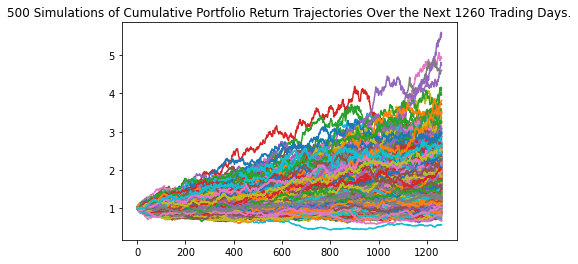

In [200]:
# Plot simulation outcomes
fiveyear_plot = MC_fiveyears.plot_simulation()

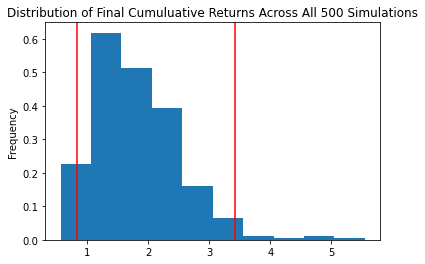

In [201]:
# Plot probability distribution and confidence intervals
fiveyear_dist_plot = MC_fiveyears.plot_distribution()

In [202]:
# Fetch summary statistics from the Monte Carlo simulation results
fiveyear_tbl = MC_fiveyears.summarize_cumulative_return()

# Print summary statistics
print(fiveyear_tbl)

count           500.000000
mean              1.818812
std               0.695736
min               0.566500
25%               1.300849
50%               1.717445
75%               2.232209
max               5.546377
95% CI Lower      0.834974
95% CI Upper      3.426770
Name: 1260, dtype: float64


In [214]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(fiveyear_tbl[8]*initial_investment,2)
ci_upper_five = round(fiveyear_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $50098.42 and $205606.22


### Ten Years Retirement Option

In [205]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyears = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [207]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\dhaam\Documents\Fintech Course\Homework\api_homework\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.014922  1.001577  0.996138  0.992106  0.997320  1.014385  1.010703   
2     1.026643  0.996364  0.989162  0.997435  1.004691  1.024540  1.002908   
3     1.027649  0.976710  0.988363  1.007005  0.993835  1.013387  1.003883   
4     1.021942  0.977675  0.990716  0.992123  1.000350  1.031089  1.004910   
...        ...       ...       ...       ...       ...       ...       ...   
2516  2.718220  2.442837  2.140669  5.250608  1.290866  3.063452  1.210858   
2517  2.735195  2.435347  2.120215  5.221525  1.307294  3.080651  1.213053   
2518  2.739064  2.445626  2.142445  5.225086  1.321604  3.069327  1.201235   
2519  2.720657  2.480615  2.117529  5.238970  1.296933  3.070999  1.205720   
2520  2.721658  2.499376  2.106702  5.205280  1.307941  3.068372  1.194985   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.996694  0.992066  1.003791  ...  0.993464  1.005879  1.002984   
2     0.989456  0.997161  1.002707  ...  0.978466  0.995349  1.006520   
3     0.991955  0.990010  1.013026  ...  0.974669  0.991943  1.015757   
4     0.998375  0.981717  1.005396  ...  0.984691  0.987456  1.013577   
...        ...       ...       ...  ...       ...       ...       ...   
2516  1.569350  0.993852  9.036350  ...  2.693067  2.607303  2.851442   
2517  1.575417  0.996829  9.166436  ...  2.687764  2.643520  2.823445   
2518  1.553729  1.004119  9.268700  ...  2.693054  2.677715  2.797430   
2519  1.568541  1.029565  9.386811  ...  2.700612  2.682406  2.796575   
2520  1.576537  1.027810  9.384993  ...  2.671606  2.692538  2.791408   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.009409  0.991982  0.999810  0.992866  1.006126  0.987583  1.000245  
2     1.000467  0.987337  0.998729  0.991593  1.002191  0.980289  1.014358  
3     1.001469  1.009592  1.007244  0.995225  1.002800  0.969455  1.009059  
4     0.996023  1.010280  1.015762  0.992276  1.005760  0.951454  0.997900  
...        ...       ...       ...       ...       ...       ...       ...  
2516  1.696873  3.744984  5.324543  1.978406  1.887516  3.001035  3.089671  
2517  1.708426  3.763391  5.294009  1.974939  1.905999  2.997714  3.081026  
2518  1.719375  3.750694  5.327921  1.992165  1.884156  2.982884  3.056945  
2519  1.727835  3.748026  5.302443  1.992003  1.894405  3.004288  3.030354  
2520  1.750448  3.751396  5.248118  2.020068  1.905592  2.985969  3.038727  

[2521 rows x 500 columns]

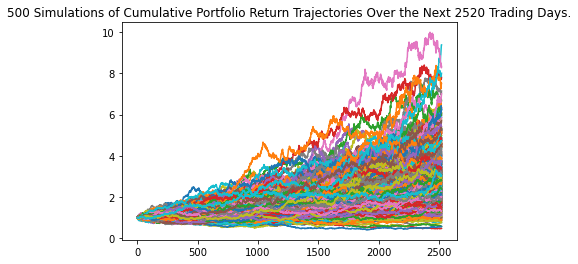

In [208]:
# Plot simulation outcomes
tenyear_line_plot = MC_tenyears.plot_simulation()

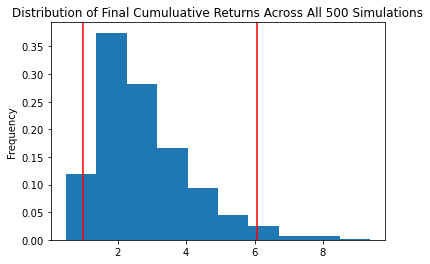

In [209]:
# Plot probability distribution and confidence intervals
tenyear_dist_plot = MC_tenyears.plot_distribution()

In [213]:
# Fetch summary statistics from the Monte Carlo simulation results
tenyear_tbl = MC_tenyears.summarize_cumulative_return()
# Print summary statistics
print(tenyear_tbl)

count           500.000000
mean              2.751064
std               1.368606
min               0.476584
25%               1.759786
50%               2.416036
75%               3.370081
max               9.384993
95% CI Lower      0.971851
95% CI Upper      6.081170
Name: 2520, dtype: float64


In [217]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tenyear_tbl[8]*initial_investment,2)
ci_upper_ten = round(tenyear_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $58311.06 and $364870.22
